In [1]:
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot Training stats

In [2]:
# Stitching Deep Learning Panorama.

In [2]:
path = '/home/gokul/CMSC733/CMSC733_Project1/Phase1/Data/Train/Set1/'

im1 = cv2.imread(path+'1.jpg')
im2 = cv2.imread(path+'2.jpg')
im1 = cv2.resize(im1, (320,240), interpolation = cv2.INTER_AREA)
im2 = cv2.resize(im2, (320,240), interpolation = cv2.INTER_AREA)

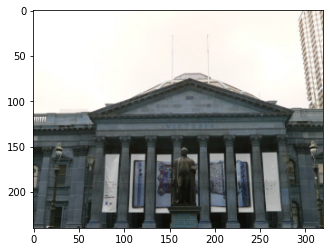

In [3]:
plt.imshow(im1)

In [4]:
def Patches4Pano(image1,image2, patch_size = 128, pixel_shift_limit = 32, border_margin = 42):
    
    """
    Inputs: 
    image: image from MS Coco dataset,
    patch_size = size of the patches to be cropped randomly, default: 128
    pixel_shift_limit = radius of pixel neigbourhood for which the corners can be chosen to obtain patch B
    border_margin = margin from the boundaries of image to crop the patch. 
                    (Choose border_margin > pixel_shift_limit)
    
    Returns:
    Patch_a : randomly cropped patch from input image
    Patch_b : patchB cropped from Image B,
    H4: The H4 point homography between Image A and Image B
    pts1,pts2: corner coordinates of Patch_a and Patch_b with respect to Image A and Image B
    """
    
    h,w = image1.shape[:2]
    minSize = patch_size+ 2*border_margin+1 # minimuum size of the image to be maintained.
    if ((w > minSize) & (h > minSize)):
        # pixel_shift_limit =  amount of random shift that the corner points can go through
        # make sure border_margin > pixel_shift_limit
         #  leave some margin space along borders 
        end_margin = patch_size + border_margin # to get right/bottom most pixel within image frame
    
    # choose left-top most point within the defined bordera
        x = np.random.randint(border_margin, w-end_margin) # left x pixel of the patch  
        y = np.random.randint(border_margin, h-end_margin) # top y pixel of the patch
    
        # choose left-top most point within the defined border
        corners = np.array([[x,y], [x, patch_size+y] , [patch_size+x, y], [patch_size+x, patch_size+y]]) # coordinates of patch P_a

        Patch_a = image1[y:y+patch_size, x:x+patch_size]
        Patch_b = image2[y:y+patch_size, x:x+patch_size]
        Patch_a = cv2.cvtColor(Patch_a, cv2.COLOR_BGR2GRAY)    
        Patch_b = cv2.cvtColor(Patch_b, cv2.COLOR_BGR2GRAY)    
        return np.dstack((Patch_a, Patch_b)), corners
    else:
        return None, None, None, None, None

def getcenterCrop(im1,im2):
    h,w  = im1.shape[:2]
    x,y = w//2,h//2
    corners = np.array([[x-64,y-64], [x-64, y+64] , [x+64, y-64], [x+64, y+64]])
    Patch_a = im1[y-64:y+64, x-64:x+64]
    Patch_b = im2[y-64:y+64, x-64:x+64]
    
    Patch_a = cv2.cvtColor(Patch_a, cv2.COLOR_BGR2GRAY)    
    Patch_b = cv2.cvtColor(Patch_b, cv2.COLOR_BGR2GRAY)
    
    return np.dstack((Patch_a, Patch_b)) , corners


In [5]:
patches,corners = getcenterCrop(im1,im2)

patchSet, cornerSet = [patches],[corners]

for _ in range(4):
    patches, corners = Patches4Pano(im1,im2, patch_size = 128, pixel_shift_limit = 32, border_margin = 42)
    patchSet.append(patches)
    cornerSet.append(corners)
    
patchSet,cornerSet = np.array(patchSet) ,np.array(cornerSet) 

In [6]:
patchSet.shape, cornerSet.shape

((5, 128, 128, 2), (5, 4, 2))

In [46]:
from Misc.MiscUtils import *
from Misc.DataUtils import *
from Network.Network import *

import tensorflow as tf

from keras import backend as K

from keras.utils import Sequence
from keras.initializers import VarianceScaling
from keras.models import Sequential
from keras.layers import  Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, InputLayer
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6627549337349641614
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 720113991119024287
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4063784077042815104
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7708311552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14801554541753810537
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Num GPUs Available:  1


In [ ]:
BasePath = "/home/gokul/CMSC733/Project1_dummy/Phase2/Data/Test_synthetic"
ModelPath = "/home/gokul/CMSC733/hgokul_p1/Phase2/Results/25kmodel/model25k.h5"
SavePath = "/home/gokul/CMSC733/Project1_dummy/Phase2/Code/Results/"

model = load_model(ModelPath, custom_objects={'L2_loss': L2_loss})
Y_pred = model.predict(patchSet)


In [ ]:
Y_pred.shape, cornerSet.shape

In [45]:
du = Y_pred[:,:4]
dv = Y_pred[:,4:]
del_corners = np.dstack((du,dv))

cornerSet2 = cornerSet + del_corners

H_list = []
for corners1,corners2 in zip(cornerSet,cornerSet2):
    H = cv2.getPerspectiveTransform(np.float32(corners1), np.float32(corners2))
    
    H_list.append(H)
H_mean = np.mean(np.array(H_list),axis=0)

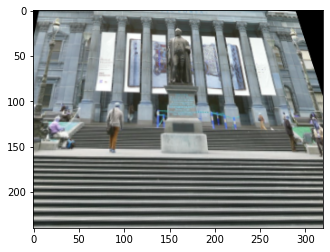

In [45]:
h,w = im1.shape[:2]
im2_ = cv2.warpPerspective(im2, H_mean, (w,h))

plt.imshow(im2_)

shapes
(240, 320, 3)
(240, 320, 3)
transformed points =  [[[  9.226693  -11.043432 ]]

 [[-61.34009   314.26608  ]]

 [[384.3655    293.734    ]]

 [[289.9193      1.4718463]]]
min, max
-61 -11
384 314


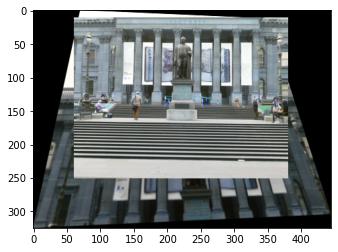

In [44]:
def stitchImagePairs(img0, img1, H):

    image0 = img0.copy()
    image1 = img1.copy()

    #stitch image 0 on image 1
    print("shapes")
    print(image0.shape)
    print(image1.shape)
    

    h0 ,w0 ,_ = image0.shape
    h1 ,w1 ,_ = image1.shape

    points_on_image0 = np.float32([[0, 0], [0, h0], [w0, h0], [w0, 0]]).reshape(-1,1,2)
    points_on_image0_transformed = cv2.perspectiveTransform(points_on_image0, H)
    print("transformed points = ", points_on_image0_transformed)
    points_on_image1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1,1,2)

    points_on_merged_images = np.concatenate((points_on_image0_transformed, points_on_image1), axis = 0)
    points_on_merged_images_ = []

    for p in range(len(points_on_merged_images)):
        points_on_merged_images_.append(points_on_merged_images[p].ravel())

    points_on_merged_images_ = np.array(points_on_merged_images_)

    x_min, y_min = np.int0(np.min(points_on_merged_images_, axis = 0))
    x_max, y_max = np.int0(np.max(points_on_merged_images_, axis = 0))

    print("min, max")
    print(x_min, y_min)
    print(x_max, y_max)

    # overlap_area = cv2.polylines(image1,[np.int32(points_on_image0_transformed)],True,255,3, cv2.LINE_AA) 
    # cv2.imshow("original_image_overlapping.jpg", overlap_area)
    # cv2.waitKey() 
    # cv2.destroyAllWindows()
    H_translate = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]]) # translate

    image0_transformed_and_stitched = cv2.warpPerspective(image0, np.dot(H_translate, H), (x_max-x_min, y_max-y_min))
    image0_transformed_and_stitched[-y_min:-y_min+h1, -x_min: -x_min+w1] = image1
    return image0_transformed_and_stitched


stitchedImage = stitchImagePairs(im1, im2, H_mean)
plt.imshow(stitchedImage)